# Pickle de los datos

In [ ]:
# Guardamos los datos de las vectorizaciones con Pickle
import pickle
pickle_file = open('vectorizaciones.plk', 'wb')
pickle.dump(vectorizaciones, pickle_file)

In [1]:
# Cargamos los datos guardados de las vectorizaciones
import pickle
pickle_file = open('vectorizaciones.plk', 'rb')
vectorizaciones = pickle.load(pickle_file)

# Carga de los datos

In [1]:
train_file = 'verbalAutopsy_train.csv'
test_file = 'verbalAutopsy_test.csv'

extended_file = 'PHMRC_VAI_redacted_free_text_1.xlsx'

model_doc2vec = 'my_doc2vec_n100.model'

In [2]:
def mapeo_de_labels(datos_df, columna):
    # PRE: docframe con todos los datos. "columna" es la entrada que contiene los labels reales
    # POST: devuelve el mismo docframe añadiendo la columna "Clases" en las cuales se mapean los valores de la
    #       columna que se recibe como parámetro en funcion del diccionario "mapeo"  
    
    mapeo = {
        'Diarrhea/Dysentery': 'Certain infectious and Parasitic Diseases',
        'Other infectious diseases': 'Certain infectious and Parasitic Diseases',
        'AIDS': 'Certain infectious and Parasitic Diseases',
        'Sepsis': 'Certain infectious and Parasitic Diseases',
        'Meningitis': 'Certain infectious and Parasitic Diseases',
        'Meningitis/Sepsis': 'Certain infectious and Parasitic Diseases',
        'Malaria': 'Certain infectious and Parasitic Diseases',
        'Encephalitis': 'Certain infectious and Parasitic Diseases',
        'Measles': 'Certain infectious and Parasitic Diseases',
        'Hemorrhagic Fever': 'Certain infectious and Parasitic Diseases',
        'TB': 'Certain infectious and Parasitic Diseases',
        'Leukemia/Lymphomas': 'Neoplasms',
        'Colorectal Cancer': 'Neoplasms',
        'Lung Cancer': 'Neoplasms',
        'Cervical Cancer': 'Neoplasms',
        'Breast Cancer': 'Neoplasms',
        'Stomach Cancer': 'Neoplasms',
        'Prostate Cancer': 'Neoplasms',
        'Esophageal Cancer': 'Neoplasms',
        'Other Cancers': 'Neoplasms',
        'Diabetes': 'Endocrine, Nutritional and Metabolic Diseases',
        'Epilepsy': 'Diseases of the Nervous System',
        'Stroke': 'Diseases of the circulatory system',
        'Acute Myocardial Infarction': 'Diseases of the circulatory system',
        'Pneumonia': 'Diseases of Respiratory System',
        'Asthma': 'Diseases of Respiratory System',
        'COPD': 'Diseases of Respiratory System',
        'Cirrhosis': 'Diseases of the Digestive System',
        'Other Digestive Diseases': 'Diseases of the Digestive System',
        'Renal Failure': 'Diseases of the Genitourinary System',
        'Preterm Delivery': 'Pregnancy, childbirth and the puerperium',
        'Stillbirth': 'Pregnancy, childbirth and the puerperium',
        'Maternal': 'Pregnancy, childbirth and the puerperium',
        'Birth Asphyxia': 'Pregnancy, childbirth and the puerperium',
        'Congenital Malformations': 'Congenital Malformations',
        'Bite of Venomous Animal': 'Injury, Poisoning and External Causes',
        'Poisonings': 'Injury, Poisoning and External Causes',
        'Road Traffic': 'External Causes of Morbidity and Mortality',
        'Falls': 'External Causes of Morbidity and Mortality',
        'Homicide': 'External Causes of Morbidity and Mortality',
        'Fires': 'External Causes of Morbidity and Mortality',
        'Drowning': 'External Causes of Morbidity and Mortality',
        'Suicide': 'External Causes of Morbidity and Mortality',
        'Violent Death': 'External Causes of Morbidity and Mortality',
        'Other injuries': 'External Causes of Morbidity and Mortality'
}

    # Aplicar el mapeo a la columna 'gs_text34'
    datos_df['Clases'] = datos_df[columna].replace(mapeo)
    return datos_df

In [3]:
import pandas as pd

datos_df = pd.read_csv(train_file)

datos = pd.read_csv(train_file)

# Realizamos un encoding de las clases de las instancias en función de un mapeo definido: Pneumonia -> 0; Stroke -> 1...
datos = mapeo_de_labels(datos, 'gs_text34') # Añade la columna 'Clases'
X = datos['open_response']

#y = datos['Clases']
y = datos['gs_text34']


# Preprocesado

In [4]:

import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocesado(documento):
    # PRE: Un texto
    # POST: Tokens del texto preprocesado
    
    tokens = simple_preprocess(documento)
    
    #tokens = [tok.lemma_.lower() for tok in doc]
    #tokens = [w.lower() for w in tokens if len(w) > 3 and w.isalpha()]
    #tokens = [w for w in tokens if not w in stop_words]
    
    return tokens


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ag6154lk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Vectorización

In [5]:
import time
# Array que almacena las diferentes vectorizaciones para la research question
vectorizaciones = [] 

In [6]:
# Vectorización con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

def vec_tfidf(X):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X)

t0 = time.time()
X_vec = vec_tfidf(X) # 0.5s
dt = time.time() - t0

vectorizaciones.append((X_vec, y, "TF-IDF", dt))

In [7]:
# Vectorización con Doc2Vec -> Tamaño de vector de 100
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec.load(model_doc2vec)

def vec_docEmbeddings(docs, model):
    # PRE: una lista de documentos y el modelo de doc-embeddings
    # POST: lista de (id, vector)
    for i, line in enumerate(docs):
        # Preprocesado del documento
        tokens = preprocesado(line)
        # Vectorizamos -> indice, vector
        yield model.infer_vector(tokens)

t0 = time.time()
X_vec = list(vec_docEmbeddings(X, model)) # 14.2s
dt = time.time() - t0
vectorizaciones.append((X_vec, y, "Doc2Vec", dt))

In [8]:
# Vectorización con Word2Vec de Google News -> Tamaño de vector de 300
import gensim.downloader as api
import numpy as np
model = api.load('word2vec-google-news-300')

In [9]:
def vec_googleEmbeddings(docs, model):
    for i, line in enumerate(docs):
        # Preprocesado del documento
        tokens = preprocesado(line)
        
        data = []
        for word in tokens:
            if word in model.key_to_index:
                data.append(model[word])
        data = np.array(data)
        
        yield np.average(data, axis=0)
        

t0 = time.time()
X_vec = list(vec_googleEmbeddings(X, model)) # 2.2s
dt = time.time() - t0
vectorizaciones.append((X_vec, y, "Google W2V", dt))

In [10]:
model['apple']

array([-0.06445312, -0.16015625, -0.01208496,  0.13476562, -0.22949219,
        0.16210938,  0.3046875 , -0.1796875 , -0.12109375,  0.25390625,
       -0.01428223, -0.06396484, -0.08056641, -0.05688477, -0.19628906,
        0.2890625 , -0.05151367,  0.14257812, -0.10498047, -0.04736328,
       -0.34765625,  0.35742188,  0.265625  ,  0.00188446, -0.01586914,
        0.00195312, -0.35546875,  0.22167969,  0.05761719,  0.15917969,
        0.08691406, -0.0267334 , -0.04785156,  0.23925781, -0.05981445,
        0.0378418 ,  0.17382812, -0.41796875,  0.2890625 ,  0.32617188,
        0.02429199, -0.01647949, -0.06494141, -0.08886719,  0.07666016,
       -0.15136719,  0.05249023, -0.04199219, -0.05419922,  0.00108337,
       -0.20117188,  0.12304688,  0.09228516,  0.10449219, -0.00408936,
       -0.04199219,  0.01409912, -0.02111816, -0.13476562, -0.24316406,
        0.16015625, -0.06689453, -0.08984375, -0.07177734, -0.00595093,
       -0.00482178, -0.00089264, -0.30664062, -0.0625    ,  0.07

In [11]:
# Vectorizacion con Sentence-transformer
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def vec_allMiniLM(docs, model):
    for doc in docs:
        yield model.encode(doc)

t0 = time.time()
X_vec = list(vec_allMiniLM(X, model)) # 39.5s
dt = time.time() - t0
vectorizaciones.append((X_vec, y, "allMiniLM", dt))

In [29]:
# Vectorizacion con transformer Roberta entrenado con Tweets
#from transformers import pipeline
#model_path = "cardiffnlp/twitter-xlm-roberta-base"
#model = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
#
#def vec_twitterXMLRobertaBase(docs, model):
#    for doc in docs:
#        tokens = preprocesado(doc)
#        yield model(tokens)
#
#t0 = time.time()       
#X_vec = list(vec_twitterXMLRobertaBase(X, model)) # > 110 min
#dt = time.time() - t0
#vectorizaciones.append((X_vec, y, "twitterXMLRobertaBase", dt))

In [30]:
# Vectorización en_core_web_trf 

import spacy_transformers
import spacy

#from thinc.api import set_gpu_allocator, require_gpu
## Use the GPU, with memory allocations directed via PyTorch.
## This prevents out-of-memory errors that would otherwise occur from competing
## memory pools.
#set_gpu_allocator("pytorch")
#require_gpu(0)

model = spacy.load("en_core_web_trf")

def vec_spacyTransformer(docs, model):
    for doc in nlp.pipe(docs):
        yield doc._.trf_data

t0 = time.time()       
X_vec = list(vec_spacyTransformer(X, model)) # 30 min
dt = time.time() - t0
vectorizaciones.append((X_vec, y, "spacyTransformer", dt))

In [12]:
# Comparar los resultados de TF-IDF con el dataset extendido
ext_data = pd.read_excel(extended_file, sheet_name='data')
ext_data
ext_data = mapeo_de_labels(ext_data, 'gs_text34') # Añade la columna 'Clases'
X_ext = datos['open_response']
#y = datos['Clases']
y_ext = datos['gs_text34']

t0 = time.time()
X_vec = vec_tfidf(X) # 0.5s
dt = time.time() - t0
vectorizaciones.append((X_vec, y_ext, "ext_TF-IDF", dt))

# Banco de pruebas

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def obtener_evaluaciones(modelo, nombreModelo, vectorizaciones, evaluaciones):
    for (vec, y, label, dt) in vectorizaciones:
        # Generar el modelo con los hyperparámetros default
        x_train, x_test, y_train, y_test = train_test_split(vec, y, test_size=0.2, random_state=42)

        # Entrenar el modelo
        modelo.fit(x_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        y_pred = modelo.predict(x_test)

        # Calcular el F-score
        score = f1_score(y_test, y_pred, average='weighted')
        evaluaciones.append((score, label, nombreModelo))
    
    return evaluaciones

models = [(LogisticRegression(random_state =42, max_iter=50000), "LogisticRegression"), (RandomForestClassifier(random_state=42), "RandomForest")]
#models = [(LogisticRegression(random_state =42, max_iter=50000), "LogisticRegression")]
evaluaciones = []
for modelo, nombreModelo in models:
    evaluaciones = obtener_evaluaciones(modelo, nombreModelo, vectorizaciones, evaluaciones)

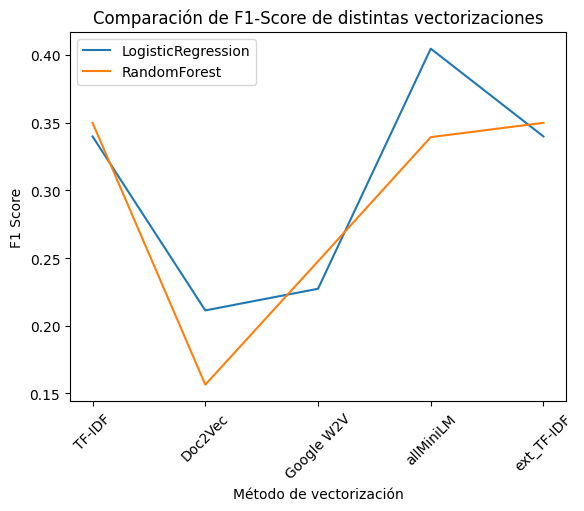

In [14]:
import matplotlib.pyplot as plt

# Graficamos los resultados
data_graficos = {}
for f1, label, nombreModelo in evaluaciones:
    if nombreModelo not in data_graficos:
        data_graficos[nombreModelo] = {}
        data_graficos[nombreModelo]['xs'] = []
        data_graficos[nombreModelo]['ys'] = []
    
    data_graficos[nombreModelo]['xs'].append(label)
    data_graficos[nombreModelo]['ys'].append(f1)

for key in data_graficos:
    xs = data_graficos[key]['xs']
    ys = data_graficos[key]['ys']
    plt.plot(xs, ys, label=key)

# Personaliza el gráfico
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Método de vectorización')
plt.title('Comparación de F1-Score de distintas vectorizaciones')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


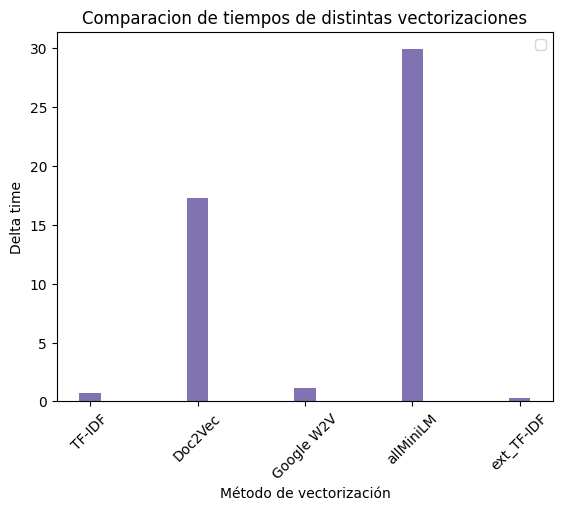

In [15]:
import matplotlib.pyplot as plt

# Graficamos los resultados
data_graficos = {}
for (vec, y, label, dt) in vectorizaciones:
    if nombreModelo not in data_graficos:
        data_graficos[nombreModelo] = {}
        data_graficos[nombreModelo]['xs'] = []
        data_graficos[nombreModelo]['ys'] = []
    
    data_graficos[nombreModelo]['xs'].append(label)
    data_graficos[nombreModelo]['ys'].append(dt)

colores_sobrios = ["#55a868", "#c44e52", "#8172b2", "#ccb974"]
for i, key in enumerate(data_graficos):
    xs = data_graficos[key]['xs']
    ys = data_graficos[key]['ys']
    plt.bar(xs, ys, width=0.2, color="#8172b2")

# Personaliza el gráfico
plt.legend()
plt.ylabel('Delta time')
plt.xlabel('Método de vectorización')
plt.title('Comparacion de tiempos de distintas vectorizaciones')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()

In [16]:
vec, y, label, dt = vectorizaciones[0]
vec.shape[1] # Longitud vector TF-IDF

9304

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


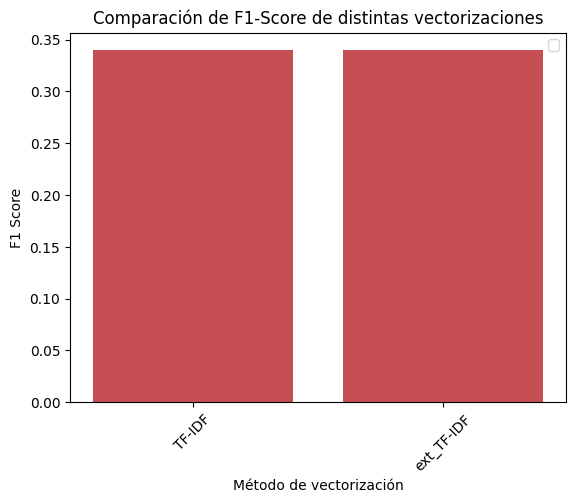

In [17]:
import matplotlib.pyplot as plt

# Graficamos los resultados
xs = ["TF-IDF", "ext_TF-IDF"]
ys = [evaluaciones[0][0], evaluaciones[4][0]]
plt.bar(xs, ys, color="#c44e52")
 
# Personaliza el gráfico
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Método de vectorización')
plt.title('Comparación de F1-Score de distintas vectorizaciones')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()

In [18]:
evaluaciones[4]

(0.3397704789290362, 'ext_TF-IDF', 'LogisticRegression')

In [32]:
vectorizaciones[1]

([array([ 0.12844923, -0.18804653, -0.50917715,  0.04010002, -0.21911313,
          0.09290978, -0.18439439,  0.59475976, -0.33550215,  0.02463913,
          0.14288878, -0.38840315, -0.05465243,  0.4197448 ,  0.3874477 ,
         -0.49289364,  0.3699415 , -0.3183583 ,  0.23062366, -0.51069605,
          0.01774361,  0.28498358, -0.24586219,  0.10919762, -0.03796547,
          0.0446311 ,  0.42535052,  0.29026783,  0.17105205,  0.11146044,
          0.28350833,  0.10467732,  0.2932936 ,  0.03267688, -0.12820359,
          0.47349912, -0.06601838, -0.08055195,  0.00286382, -0.14764376,
         -0.81265247, -0.16691431, -0.02837509, -0.13838665, -0.09255751,
         -0.19622175, -0.4186908 , -0.22852749, -0.14185788, -0.5955902 ,
         -0.17454766, -0.39632466,  0.18942375,  0.3260789 ,  0.01415353,
         -0.33967805,  0.28770876,  0.12090187, -0.4211995 , -0.0061758 ,
          0.35470805,  0.05563285,  0.7596351 ,  0.10780723, -0.10392447,
          0.46874624,  0.09963714,  0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


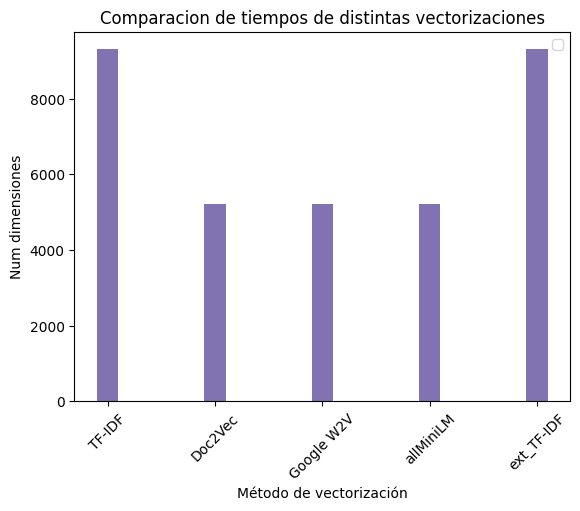

In [34]:
import matplotlib.pyplot as plt


xs = [ "TF-IDF", "Doc2Vec", "Google W2V", "allMiniLM", "ext_TF-IDF" ]
ys = [ vectorizaciones[0][0].shape[1],  len(vectorizaciones[1][0]), len(vectorizaciones[2][0]), len(vectorizaciones[3][0]), vectorizaciones[4][0].shape[1]]
plt.bar(xs, ys, width=0.2, color="#8172b2")

# Personaliza el gráfico
plt.legend()
plt.ylabel('Num dimensiones')
plt.xlabel('Método de vectorización')
plt.title('Comparacion de tiempos de distintas vectorizaciones')
plt.xticks(rotation=45)  # Rota las etiquetas del eje x para mayor legibilidad

# Muestra el gráfico
plt.show()